In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from rapidfuzz import process, fuzz
import seaborn as sns


In [ ]:
SEED = 24
RUN_FINE_TUNING = False

In [ ]:
!wget https://raw.githubusercontent.com/tomasbelak24/matfyzuk-ml-project/refs/heads/main/shot_logs.csv

--2025-01-05 14:52:08--  https://raw.githubusercontent.com/tomasbelak24/matfyzuk-ml-project/refs/heads/main/shot_logs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16423917 (16M) [text/plain]
Saving to: ‘shot_logs.csv.2’

shot_logs.csv.2     100%[===================>]  15.66M  --.-KB/s    in 0.1s    

2025-01-05 14:52:09 (149 MB/s) - ‘shot_logs.csv.2’ saved [16423917/16423917]



In [ ]:
df = pd.read_csv("shot_logs.csv", sep=',')
df.columns = df.columns.str.upper()
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [ ]:
df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'PLAYER_NAME', 'PLAYER_ID'],
      dtype='object')

In [ ]:
df.shape

(128069, 21)

In [ ]:
df.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_ID
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


In [ ]:
df.isna().sum()


,0
GAME_ID,0
MATCHUP,0
LOCATION,0
W,0
FINAL_MARGIN,0
SHOT_NUMBER,0
PERIOD,0
GAME_CLOCK,0
SHOT_CLOCK,5567
DRIBBLES,0


In [ ]:
df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'PLAYER_NAME', 'PLAYER_ID'],
      dtype='object')

In [ ]:
df['SHOT_RESULT'].value_counts() / df['SHOT_RESULT'].count()


,count
SHOT_RESULT,
missed,0.547861
made,0.452139


In [ ]:
df['PLAYER_NAME'].describe()

,PLAYER_NAME
count,128069
unique,281
top,james harden
freq,1054


# I. DATA PRE-PROCESSING
Here I do:
- Data cleaning
- Data enrichment
- Feature engineering

In [ ]:
df_prep = df.copy()
np.random.seed(24)

In [ ]:
df_prep.dtypes

,0
GAME_ID,int64
MATCHUP,object
LOCATION,object
W,object
FINAL_MARGIN,int64
SHOT_NUMBER,int64
PERIOD,int64
GAME_CLOCK,object
SHOT_CLOCK,float64
DRIBBLES,int64


In [ ]:
# @title Teams
df_prep['MATCHUP'] = df['MATCHUP'].apply(lambda x: x.replace('vs.', '@'))

def which_team(row, shooter=True):
  teams = row['MATCHUP'].split('-')[1].split(' @ ')
  if shooter:
    return teams[0]
  return teams[1]

df_prep['TEAM_OFFENSE'] = df_prep.apply(lambda row: which_team(row), axis=1)
df_prep['TEAM_DEFENSE'] = df_prep.apply(lambda row: which_team(row, shooter=False), axis=1)
df_prep.sample(15)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,TEAM_OFFENSE,TEAM_DEFENSE
118681,21400712,"JAN 31, 2015 - POR @ MIL",A,L,-7,5,1,3:16,15.9,0,...,missed,"Middleton, Khris",203114,6.3,0,0,damian lillard,203081,POR,MIL
15613,21400365,"DEC 16, 2014 - GSW @ MEM",A,L,-7,11,3,9:07,6.3,9,...,missed,"Allen, Tony",2754,6.3,0,0,klay thompson,202691,GSW,MEM
96483,21400112,"NOV 12, 2014 - MIA @ IND",H,L,-6,3,1,7:49,5.3,2,...,missed,"Hill, Solomon",203524,4.0,0,0,dwayne wade,2548,MIA,IND
98657,21400139,"NOV 15, 2014 - SAC @ SAS",H,W,3,3,2,5:00,13.6,1,...,missed,"Green, Danny",201980,2.3,0,0,carl landry,201171,SAC,SAS
71660,21400726,"FEB 03, 2015 - PHI @ DEN",H,W,7,4,2,3:09,11.0,4,...,missed,"Hickson, JJ",201581,1.7,0,0,nerles noel,203457,PHI,DEN
100412,21400792,"FEB 11, 2015 - SAC @ MIL",A,L,-8,9,2,6:19,10.4,1,...,made,"O'Bryant, Johnny",203948,0.9,1,2,demarcus cousins,202326,SAC,MIL
83760,21400353,"DEC 14, 2014 - NYK @ TOR",H,L,-5,3,3,6:13,8.3,0,...,made,"Johnson, Amir",101161,3.9,1,2,quincy acy,203112,NYK,TOR
105426,21400382,"DEC 18, 2014 - OKC @ GSW",A,L,-5,13,3,9:41,17.5,0,...,missed,"Green, Draymond",203110,3.6,0,0,russell westbrook,201566,OKC,GSW
93715,21400617,"JAN 19, 2015 - HOU @ IND",H,W,12,2,1,3:55,15.8,0,...,made,"Hill, Solomon",203524,1.4,1,2,dwight howard,2730,HOU,IND
11875,21400248,"NOV 30, 2014 - LAL @ TOR",H,W,7,1,1,8:33,12.6,0,...,made,"Vasquez, Greivis",202349,4.2,1,2,wesley johnson,202325,LAL,TOR


In [ ]:
# @title Fixing clock data
def calculate_remaining_seconds(game_clock):
  minutes, seconds = map(int, game_clock.split(':'))
  return minutes * 60 + seconds

def adjust_touch_time(touch_time):
  if touch_time > 24:
    return 24.0
  if touch_time < 0:
    return pd.NA
  return touch_time

#parameters for gamma distribution
zero_dribbles_df = df_prep[df_prep['DRIBBLES'] == 0]
zero_dribbles_mean = zero_dribbles_df['TOUCH_TIME'].mean()
zero_dribbles_var = zero_dribbles_df['TOUCH_TIME'].std() ** 2
shape, scale = zero_dribbles_mean ** 2 / zero_dribbles_var, zero_dribbles_var / zero_dribbles_mean


def impute_touch_time(row):
  if pd.isna(row['TOUCH_TIME']) and pd.notna(row['SHOT_CLOCK']):
      max_touch_time = 24 - row['SHOT_CLOCK']
      if row['DRIBBLES'] == 0:
          while True:
            new = round(np.random.gamma(shape, scale), 1)  # mean and std of touch time of shots with 0 dribbles
            if new <= max_touch_time:
              return new
      else:
        return round(np.random.uniform(0, 24-row['SHOT_CLOCK']), 1)
  return row['TOUCH_TIME']

df_prep['SECONDS_REMAINING'] = df['GAME_CLOCK'].apply(lambda game_clock: calculate_remaining_seconds(game_clock))
df_prep['SHOT_CLOCK'] = df_prep.apply(lambda row: row['SECONDS_REMAINING'] if row['SHOT_CLOCK'] and row['SECONDS_REMAINING'] < 24 else row['SHOT_CLOCK'], axis=1)

team_median_shot_clock = df_prep.groupby('TEAM_OFFENSE')['SHOT_CLOCK'].median()
def impute_shot_clock(row):
    if pd.isna(row['SHOT_CLOCK']):
        return team_median_shot_clock.get(row['TEAM_OFFENSE'], df_prep['SHOT_CLOCK'].median())
    return row['SHOT_CLOCK']

df_prep['SHOT_CLOCK'] = df_prep.apply(lambda row: impute_shot_clock(row), axis=1) # imputes missing shotclocks with the median shot clock value for a team trying to represent teams offensive tendencies
df_prep['TOUCH_TIME'] = df['TOUCH_TIME'].apply(lambda touch_time: adjust_touch_time(touch_time)) # produced 312 rows with NA touch time
na_touch_time_indices = df_prep[df_prep['TOUCH_TIME'].isna()].index
df_prep['TOUCH_TIME'] = df_prep.apply(lambda row: impute_touch_time(row), axis=1) # fills all missing values


df_prep.sample(10)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,TEAM_OFFENSE,TEAM_DEFENSE,SECONDS_REMAINING
100102,21400039,"NOV 02, 2014 - SAC @ LAC",A,W,6,1,1,11:35,16.7,3,...,"Griffin, Blake",201933,1.6,0,0,darren collison,201954,SAC,LAC,695
106042,21400738,"FEB 04, 2015 - OKC @ NOP",A,W,11,4,2,1:06,20.1,1,...,"Davis, Anthony",203076,7.4,1,2,steve adams,203500,OKC,NOP,66
56770,21400404,"DEC 21, 2014 - BOS @ MIA",A,L,-16,3,1,3:29,20.3,1,...,"Deng, Luol",2736,2.1,0,0,jeff green,201145,BOS,MIA,209
10905,21400562,"JAN 11, 2015 - LAL @ POR",H,L,-12,6,4,4:44,15.6,1,...,"Batum, Nicolas",201587,3.3,0,0,ronnie price,101179,LAL,POR,284
23177,21400363,"DEC 16, 2014 - WAS @ MIN",H,W,14,5,3,6:28,24.0,0,...,"Brewer, Corey",201147,0.8,0,0,otto porter,203490,WAS,MIN,388
17960,21400779,"FEB 09, 2015 - ATL @ MIN",A,W,12,4,2,9:35,14.7,0,...,"Dieng, Gorgui",203476,5.1,0,0,al horford,201143,ATL,MIN,575
92417,21400698,"JAN 30, 2015 - HOU @ BOS",A,W,6,5,1,0:54,16.0,0,...,"Smart, Marcus",203935,2.8,1,3,james harden,201935,HOU,BOS,54
125165,21400635,"JAN 21, 2015 - BKN @ SAC",A,W,3,3,3,7:38,2.4,0,...,"Gay, Rudy",200752,7.3,1,2,kevin garnett,708,BKN,SAC,458
77143,21400895,"MAR 03, 2015 - MIL @ DEN",A,L,-11,10,3,9:23,5.4,0,...,"Foye, Randy",200751,1.9,1,2,khris middleton,203114,MIL,DEN,563
62512,21400067,"NOV 05, 2014 - DEN @ SAC",A,L,-22,8,3,8:20,12.2,1,...,"Cousins, DeMarcus",202326,3.7,0,0,nate robinson,101126,DEN,SAC,500


In [ ]:
df_prep.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_ID,SECONDS_REMAINING
count,1.280690e+05,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.325324,2.023355,2.773859,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247,351.393811
std,2.578773e+02,13.233267,4.713260,1.139919,5.826583,3.477760,2.985480,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336,207.590603
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000,0.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.100000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000,172.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.100000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000,352.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.500000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000,531.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.000000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000,720.000000


In [ ]:
df_prep.isna().sum()


,0
GAME_ID,0
MATCHUP,0
LOCATION,0
W,0
FINAL_MARGIN,0
SHOT_NUMBER,0
PERIOD,0
GAME_CLOCK,0
SHOT_CLOCK,0
DRIBBLES,0


In [ ]:
df_prep.loc[na_touch_time_indices]

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,TEAM_OFFENSE,TEAM_DEFENSE,SECONDS_REMAINING
748,21400625,"JAN 21, 2015 - CHA @ MIA",H,W,2,7,4,7:55,9.0,0,...,"Napier, Shabazz",203894,3.9,1,2,al jefferson,2744,CHA,MIA,475
775,21400459,"DEC 29, 2014 - CHA @ MIL",H,L,-10,12,4,7:34,6.3,0,...,"Henson, John",203089,0.1,0,0,al jefferson,2744,CHA,MIL,454
1043,21400195,"NOV 23, 2014 - CHA @ MIA",A,L,-1,17,4,0:02,2.0,0,...,"Williams, Shawne",200761,1.3,0,0,al jefferson,2744,CHA,MIA,2
1118,21400130,"NOV 14, 2014 - CHA @ PHX",A,W,8,7,2,5:36,17.7,0,...,"Plumlee, Miles",203101,3.7,1,2,al jefferson,2744,CHA,PHX,336
1260,21400028,"NOV 01, 2014 - CHA @ MEM",H,L,-2,9,3,11:00,23.7,0,...,"Conley, Mike",201144,0.6,0,0,al jefferson,2744,CHA,MEM,660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124820,21400590,"JAN 16, 2015 - BKN @ WAS",A,W,22,10,3,9:31,16.8,0,...,"Gortat, Marcin",101162,0.0,0,0,mason plumlee,203486,BKN,WAS,571
125018,21400266,"DEC 03, 2014 - BKN @ SAS",H,W,2,3,4,8:18,19.5,0,...,"Bonner, Matt",2588,1.0,0,0,mason plumlee,203486,BKN,SAS,498
125057,21400116,"NOV 12, 2014 - BKN @ PHX",A,L,-8,2,4,9:43,14.3,0,...,"Morris, Marcus",202694,2.0,0,0,mason plumlee,203486,BKN,PHX,583
125059,21400090,"NOV 09, 2014 - BKN @ ORL",H,W,8,2,2,11:20,21.6,0,...,"Frye, Channing",101112,2.0,0,0,mason plumlee,203486,BKN,ORL,680


In [ ]:
# @title Name standardization
df_prep['CLOSEST_DEFENDER'] = df['CLOSEST_DEFENDER'].apply(lambda name: ' '.join(name.split(', ')[::-1]))
df_prep['PLAYER_NAME'] = df['PLAYER_NAME'].apply(lambda name: ' '.join([x.capitalize() for x in name.split(' ')]))
df_prep.sample(7)


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,TEAM_OFFENSE,TEAM_DEFENSE,SECONDS_REMAINING
100233,21400368,"DEC 16, 2014 - SAC @ OKC",H,L,-12,1,1,2:03,11.9,3,...,Jeremy Lamb,203087,5.1,0,0,Nik Stauskas,203917,SAC,OKC,123
21947,21400032,"NOV 01, 2014 - ATL @ IND",H,W,10,4,1,5:19,12.3,4,...,CJ Miles,101139,1.6,0,0,Jeff Teague,201952,ATL,IND,319
91098,21400240,"NOV 29, 2014 - HOU @ MIL",A,W,14,7,2,8:01,23.4,0,...,Brandon Knight,202688,8.1,0,0,Trevor Ariza,2772,HOU,MIL,481
13388,21400838,"FEB 24, 2015 - GSW @ WAS",A,W,7,11,4,2:58,6.1,0,...,Rasual Butler,2446,5.0,1,2,Harrison Barnes,203084,GSW,WAS,178
121353,21400596,"JAN 16, 2015 - MIN @ PHX",A,L,-11,1,1,11:21,8.7,1,...,Eric Bledsoe,202339,13.7,1,3,Mo Williams,2590,MIN,PHX,681
111397,21400101,"NOV 10, 2014 - CHI @ DET",H,W,11,2,3,3:44,10.4,4,...,Brandon Jennings,201943,1.6,0,0,Kirk Hinrich,2550,CHI,DET,224
2507,21400384,"DEC 19, 2014 - CHA @ PHI",A,W,18,9,3,9:10,16.6,5,...,Henry Sims,203156,3.2,0,0,Gerald Henderson,201945,CHA,PHI,550


In [ ]:
# @title Joining NBA2k15 ratings of the shooter and closest defender
!wget -O ratings.csv  https://raw.githubusercontent.com/tomasbelak24/matfyzuk-ml-project/refs/heads/main/nba2k15_player_ratings.csv
!pip install rapidfuzz

--2025-01-05 14:52:21--  https://raw.githubusercontent.com/tomasbelak24/matfyzuk-ml-project/refs/heads/main/nba2k15_player_ratings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9671 (9.4K) [text/plain]
Saving to: ‘ratings.csv’

ratings.csv         100%[===================>]   9.44K  --.-KB/s    in 0s      

2025-01-05 14:52:21 (68.7 MB/s) - ‘ratings.csv’ saved [9671/9671]



In [ ]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.columns = df_ratings.columns.str.upper()
df_ratings.head()

,COLUMN1,PLAYER_NAME,RATING
0,1,LeBron James,98
1,2,Kevin Durant,95
2,3,Chris Paul,91
3,4,Tim Duncan,90
4,5,Carmelo Anthony,89


In [ ]:
df_ratings['PLAYER_NAME'].describe() #fortunately all names are unique

,PLAYER_NAME
count,448
unique,448
top,LeBron James
freq,1


In [ ]:
# Function to find the best match based on string similarity
def find_best_match(source_col, target_col):
    matches = source_col.apply(
        lambda x: process.extractOne(x, target_col, scorer=fuzz.ratio) if pd.notna(x) else (None, 0)
    )
    return pd.DataFrame({
        'source': source_col,
        'best_match': matches.apply(lambda x: x[0] if x else None),
        'similarity': matches.apply(lambda x: x[1] if x else 0)
    })

player_matches = find_best_match(df_prep['PLAYER_NAME'], df_ratings['PLAYER_NAME'])
df_prep['player_match'] = player_matches['best_match']
df_prep['player_similarity'] = player_matches['similarity']

defender_matches = find_best_match(df_prep['CLOSEST_DEFENDER'], df_ratings['PLAYER_NAME'])
df_prep['defender_match'] = defender_matches['best_match']
df_prep['defender_similarity'] = defender_matches['similarity']

df_prep = df_prep.merge(df_ratings[['PLAYER_NAME', 'RATING']],
                        left_on='player_match',
                        right_on='PLAYER_NAME',
                        how='left',
                        suffixes=('', '_SHOOTER'))

df_prep = df_prep.merge(df_ratings[['PLAYER_NAME', 'RATING']],
                        left_on='defender_match',
                        right_on='PLAYER_NAME',
                        how='left',
                        suffixes=('', '_DEFENDER'))

df_prep.drop(columns=['PLAYER_NAME_SHOOTER', 'PLAYER_NAME_DEFENDER', 'player_match', 'player_similarity', 'defender_match', 'defender_similarity'], inplace=True)

df_prep['RATING_DIFF'] = df_prep['RATING'] - df_prep['RATING_DEFENDER']

df_prep.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,FGM,PTS,PLAYER_NAME,PLAYER_ID,TEAM_OFFENSE,TEAM_DEFENSE,SECONDS_REMAINING,RATING,RATING_DEFENDER,RATING_DIFF
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,1,2,Brian Roberts,203148,CHA,BKN,69,74,71,3
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,14.0,0,...,0,0,Brian Roberts,203148,CHA,BKN,14,74,72,2
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,0,0,Brian Roberts,203148,CHA,BKN,0,74,72,2
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,0,0,Brian Roberts,203148,CHA,BKN,707,74,68,6
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,0,0,Brian Roberts,203148,CHA,BKN,634,74,78,-4


In [ ]:
df_prep[['RATING', 'RATING_DEFENDER']].isna().sum()

,0
RATING,0
RATING_DEFENDER,0


In [ ]:
df_prep.shape

(128069, 27)

In [ ]:
# @title Determining the contest level of the shot
# Assuming that each player is 6.56 ft tall (2m) so eyelevel at around 6.1ft (1.85m) and each defender with his hand slighly raised rises up to 8.5ft (around 2.6m)
# calculate the angle between shooter eyelevel and the hoop which is at 10ft, and shooter eyelevel and defender raised hand at 2.6, then compare the angles, if the difference is positive then no contest or open shot, otherwise determine light contest, contest, heavy contest

def calculate_hoop_angle(row):
  hoop_height = 10
  estimated_height_of_player = 6.56
  b = row['SHOT_DIST'] if row['SHOT_DIST'] != 0 else 0.1
  a = 10 -  6.56
  return np.degrees(np.arctan(a/b))

def calculate_defender_angle(row):
  estimated_height_of_defender = 8.5
  estimated_height_of_player = 6.56
  b = row['CLOSE_DEF_DIST'] if row['CLOSE_DEF_DIST'] != 0 else 0.1
  a = estimated_height_of_defender - estimated_height_of_player
  return np.degrees(np.arctan(a/b))

df_prep['hoop_angle'] = df_prep.apply(lambda row: calculate_hoop_angle(row), axis=1)
df_prep['defender_angle'] = df_prep.apply(lambda row: calculate_defender_angle(row), axis=1)
df_prep['ANGLE_DIFFERENCE'] = df_prep['hoop_angle'] - df_prep['defender_angle']
df_prep.sample(10)


,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,PLAYER_ID,TEAM_OFFENSE,TEAM_DEFENSE,SECONDS_REMAINING,RATING,RATING_DEFENDER,RATING_DIFF,hoop_angle,defender_angle,ANGLE_DIFFERENCE
102150,21400244,"NOV 30, 2014 - SAC @ MEM",H,L,-12,3,3,0:30,2.7,8,...,201956,SAC,MEM,30,72,68,4,28.258030,41.406434,-13.148404
63334,21400766,"FEB 08, 2015 - CLE @ LAL",H,W,15,6,2,1:04,12.3,0,...,202389,CLE,LAL,64,74,67,7,55.097504,40.146904,14.950601
39768,21400323,"DEC 10, 2014 - DAL @ NOP",H,W,5,6,2,9:30,14.8,0,...,1717,DAL,NOP,570,88,77,11,10.533614,31.226338,-20.692724
17031,21400824,"FEB 22, 2015 - GSW @ IND",A,L,-6,5,2,7:20,15.2,9,...,2738,GSW,IND,440,82,69,13,10.004627,27.669116,-17.664488
98454,21400820,"FEB 21, 2015 - SAC @ LAC",A,L,-27,5,4,10:35,17.0,0,...,201171,SAC,LAC,635,75,76,-1,11.439502,18.494200,-7.054698
102029,21400867,"FEB 27, 2015 - SAC @ SAS",H,L,-11,8,4,10:53,12.9,2,...,201956,SAC,SAS,653,72,68,4,32.985853,78.349701,-45.363848
73727,21400682,"JAN 28, 2015 - PHI @ DET",H,W,20,5,3,5:57,3.2,2,...,203960,PHI,DET,357,64,71,-7,39.997470,25.322142,14.675328
38310,21400180,"NOV 21, 2014 - DAL @ LAL",H,W,34,7,4,11:44,8.2,0,...,202329,DAL,LAL,704,74,70,4,30.672326,48.772284,-18.099958
39379,21400781,"FEB 09, 2015 - DAL @ LAC",H,L,-17,4,2,0:47,8.0,1,...,1717,DAL,LAC,47,88,81,7,9.174187,16.618341,-7.444154
9767,21400097,"NOV 09, 2014 - LAL @ CHA",H,W,15,7,3,9:54,20.5,0,...,202391,LAL,CHA,594,77,73,4,73.790975,29.708572,44.082403


In [ ]:
df_prep['ANGLE_DIFFERENCE'].describe()

,ANGLE_DIFFERENCE
count,128069.000000
mean,-7.841181
std,17.695542
min,-82.578826
25%,-16.849717
50%,-9.960025
75%,-1.805112
max,77.709538


In [ ]:
def get_contest_level_2(angle_diff):
  if angle_diff >= 0:
    return 'OPEN SHOT'
  if angle_diff >= -10:
    return 'LIGHT CONTEST'
  if angle_diff >= -20:
    return 'CONTEST'
  return 'HEAVY CONTEST'

def get_contest_level(def_distance):
  if def_distance <= 2:
    return 'HEAVY CONTEST'
  if def_distance <= 4:
    return 'CONTEST'
  if def_distance <= 6:
    return 'LIGHT CONTEST'
  return 'OPEN SHOT'

df_prep['CONTEST_LEVEL_2'] = df_prep['ANGLE_DIFFERENCE'].apply(lambda angle_diff: get_contest_level_2(angle_diff))
df_prep['CONTEST_LEVEL'] = df_prep['CLOSE_DEF_DIST'].apply(lambda def_dist: get_contest_level(def_dist)) # At the end I decided to use the defender distance based contest level as I realized the angle difference contest level does not work that well for longer shots as the angle of shooter with the basket gets
                                                                                                          # more acute and therefore the defender that is relatively far from the shooter would still cause negative angle difference and inappropriate contest level label

df_prep[['FGM', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'ANGLE_DIFFERENCE', 'CONTEST_LEVEL', 'CONTEST_LEVEL_2']].sample(10)

,FGM,SHOT_DIST,CLOSE_DEF_DIST,ANGLE_DIFFERENCE,CONTEST_LEVEL,CONTEST_LEVEL_2
71596,0,17.3,7.7,-2.895017,OPEN SHOT,LIGHT CONTEST
93469,0,2.9,3.3,19.417965,CONTEST,OPEN SHOT
108281,1,12.5,4.0,-10.486481,CONTEST,CONTEST
77665,0,20.6,4.6,-13.386694,LIGHT CONTEST,CONTEST
76583,0,1.3,0.0,-17.751149,HEAVY CONTEST,CONTEST
56488,1,4.8,0.0,-51.421314,HEAVY CONTEST,HEAVY CONTEST
49391,0,5.7,2.5,-6.700113,CONTEST,LIGHT CONTEST
110753,1,7.4,2.1,-17.799984,CONTEST,CONTEST
28469,0,26.1,5.2,-12.951034,LIGHT CONTEST,CONTEST
20600,0,24.2,2.9,-25.690835,CONTEST,HEAVY CONTEST


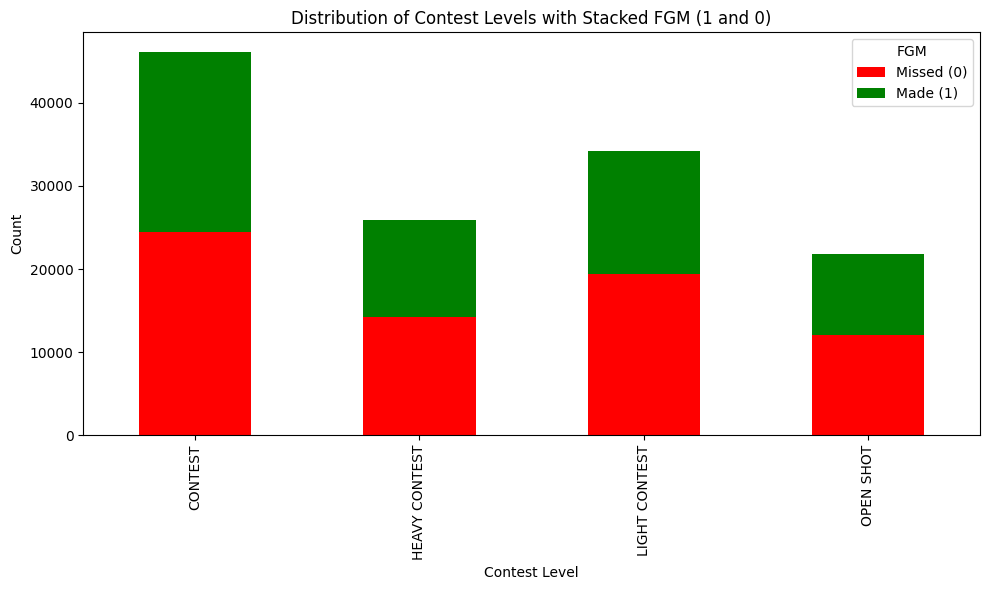

In [ ]:
contest_fgm_count = df_prep.groupby(['CONTEST_LEVEL', 'FGM']).size().unstack(fill_value=0)

contest_fgm_count.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(10, 6))

plt.xlabel('Contest Level')
plt.ylabel('Count')
plt.title('Distribution of Contest Levels with Stacked FGM (1 and 0)')
plt.legend(title="FGM", labels=["Missed (0)", "Made (1)"])

plt.tight_layout()
plt.show()

In [ ]:
# @title Determining wether its a 'clutch' moment
# According to ChatGPT all shots within the last 8 minutes of 4th quarter of a close game (margin of 0-15 pts) could be labeled as clutch
# Also all overtime shots could be labeled as clutch

def is_clutch(row):
  if row['PERIOD'] == 4 and row['SECONDS_REMAINING'] <= 8*60 and abs(row['FINAL_MARGIN']) <= 8:
    return True
  if row['PERIOD'] > 4:
    return True
  return False

def shot_clock_pressure(shot_clock):
  if shot_clock < 2:
    return 1
  return 0

df_prep['IS_CLUTCH'] = df_prep.apply(lambda row: is_clutch(row), axis=1)
df_prep['SHOT_CLOCK_PRESS'] = df_prep['SHOT_CLOCK'].apply(lambda sh: shot_clock_pressure(sh))
df_prep.head(10)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,RATING,RATING_DEFENDER,RATING_DIFF,hoop_angle,defender_angle,ANGLE_DIFFERENCE,CONTEST_LEVEL_2,CONTEST_LEVEL,IS_CLUTCH,SHOT_CLOCK_PRESS
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,74,71,3,24.072859,56.173838,-32.100979,HEAVY CONTEST,HEAVY CONTEST,False,0
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,14.0,0,...,74,72,2,6.954911,17.642370,-10.687459,CONTEST,OPEN SHOT,False,0
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,74,72,2,18.808538,65.112588,-46.304050,HEAVY CONTEST,HEAVY CONTEST,False,1
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,74,68,6,11.309932,29.708572,-18.398640,CONTEST,CONTEST,False,0
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,74,78,-4,42.914521,60.446316,-17.531796,CONTEST,HEAVY CONTEST,False,0
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,74,84,-10,10.589571,36.728601,-26.139030,HEAVY CONTEST,CONTEST,False,0
6,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,7,4,10:15,14.5,11,...,74,74,0,9.435389,17.642370,-8.206981,LIGHT CONTEST,OPEN SHOT,False,0
7,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,4,8:00,3.4,3,...,74,77,-3,44.504660,42.732045,1.772614,OPEN SHOT,CONTEST,False,0
8,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,9,4,5:14,12.4,0,...,74,75,-1,7.960473,14.882555,-6.922082,LIGHT CONTEST,OPEN SHOT,False,0
9,21400890,"MAR 03, 2015 - CHA @ LAL",H,W,1,1,2,11:32,17.4,0,...,74,71,3,8.730785,5.595967,3.134818,OPEN SHOT,OPEN SHOT,False,0


In [ ]:
# @title 3pointer ? Was it a corner three ?
# 3pt shot from a corner is actually the shortest 3pt shot (22ft compared to 23ft) and NBA players score siginificantly better % from corner threes (2-3% better)

def is_corner_three(row):
  if row['PTS_TYPE'] == 3 and row['SHOT_DIST'] < 23:
    return 1
  return 0

df_prep['3PT_SHOT'] = df_prep['PTS_TYPE'].apply(lambda pt: 1 if pt == 3 else 0)
df_prep['IS_CORNER_THREE'] = df_prep.apply(lambda row: is_corner_three(row), axis=1)
df_prep.head(10)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,RATING_DIFF,hoop_angle,defender_angle,ANGLE_DIFFERENCE,CONTEST_LEVEL_2,CONTEST_LEVEL,IS_CLUTCH,SHOT_CLOCK_PRESS,3PT_SHOT,IS_CORNER_THREE
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,3,24.072859,56.173838,-32.100979,HEAVY CONTEST,HEAVY CONTEST,False,0,0,0
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,14.0,0,...,2,6.954911,17.642370,-10.687459,CONTEST,OPEN SHOT,False,0,1,0
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,2,18.808538,65.112588,-46.304050,HEAVY CONTEST,HEAVY CONTEST,False,1,0,0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,6,11.309932,29.708572,-18.398640,CONTEST,CONTEST,False,0,0,0
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,-4,42.914521,60.446316,-17.531796,CONTEST,HEAVY CONTEST,False,0,0,0
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,-10,10.589571,36.728601,-26.139030,HEAVY CONTEST,CONTEST,False,0,0,0
6,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,7,4,10:15,14.5,11,...,0,9.435389,17.642370,-8.206981,LIGHT CONTEST,OPEN SHOT,False,0,0,0
7,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,4,8:00,3.4,3,...,-3,44.504660,42.732045,1.772614,OPEN SHOT,CONTEST,False,0,0,0
8,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,9,4,5:14,12.4,0,...,-1,7.960473,14.882555,-6.922082,LIGHT CONTEST,OPEN SHOT,False,0,1,0
9,21400890,"MAR 03, 2015 - CHA @ LAL",H,W,1,1,2,11:32,17.4,0,...,3,8.730785,5.595967,3.134818,OPEN SHOT,OPEN SHOT,False,0,1,1


In [ ]:
# @title Play types
def get_play_type(row):
  if row['DRIBBLES'] == 0:
    if row['SHOT_DIST'] > 5:
      return 'CATCH&SHOOT'
    return 'CUT'
  if row['DRIBBLES'] >= 5:
    return 'ISO/POSTUP'
  if row['DRIBBLES'] > 0 and row['SHOT_DIST'] <= 5:
    return 'DRIVE'
  if row['DRIBBLES'] > 0 and row['SHOT_DIST'] > 5:
    return 'PULLUP'
  return 'OTHER'

def is_fastbreak(shot_clock):
   if shot_clock > 17:
      return 1
   return 0


df_prep['PLAY_TYPE'] = df_prep.apply(lambda row: get_play_type(row), axis=1)
df_prep['IS_FASTBREAK'] = df_prep['SHOT_CLOCK'].apply(lambda sh: is_fastbreak(sh))
df_prep.head(10)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,defender_angle,ANGLE_DIFFERENCE,CONTEST_LEVEL_2,CONTEST_LEVEL,IS_CLUTCH,SHOT_CLOCK_PRESS,3PT_SHOT,IS_CORNER_THREE,PLAY_TYPE,IS_FASTBREAK
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,56.173838,-32.100979,HEAVY CONTEST,HEAVY CONTEST,False,0,0,0,PULLUP,0
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,14.0,0,...,17.642370,-10.687459,CONTEST,OPEN SHOT,False,0,1,0,CATCH&SHOOT,0
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,65.112588,-46.304050,HEAVY CONTEST,HEAVY CONTEST,False,1,0,0,PULLUP,0
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,29.708572,-18.398640,CONTEST,CONTEST,False,0,0,0,PULLUP,0
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,60.446316,-17.531796,CONTEST,HEAVY CONTEST,False,0,0,0,DRIVE,0
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,36.728601,-26.139030,HEAVY CONTEST,CONTEST,False,0,0,0,PULLUP,0
6,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,7,4,10:15,14.5,11,...,17.642370,-8.206981,LIGHT CONTEST,OPEN SHOT,False,0,0,0,ISO/POSTUP,0
7,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,4,8:00,3.4,3,...,42.732045,1.772614,OPEN SHOT,CONTEST,False,0,0,0,DRIVE,0
8,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,9,4,5:14,12.4,0,...,14.882555,-6.922082,LIGHT CONTEST,OPEN SHOT,False,0,1,0,CATCH&SHOOT,0
9,21400890,"MAR 03, 2015 - CHA @ LAL",H,W,1,1,2,11:32,17.4,0,...,5.595967,3.134818,OPEN SHOT,OPEN SHOT,False,0,1,1,CATCH&SHOOT,1


In [ ]:
# @title Calculating percentages

def calculate_percentage(df, aggregate_col, indicator_col, new_col_name, inv = False):
    indicator_sum = df.groupby(aggregate_col)[indicator_col].sum()
    total_rows = df.groupby(aggregate_col).size()
    if inv:
      percentage = (1- (indicator_sum / total_rows)) * 100
    else:
      percentage = (indicator_sum / total_rows) * 100

    df[new_col_name] = df[aggregate_col].map(round(percentage, 2))

    return df

In [ ]:
# @title Shooter and defender percentages
df_prep = calculate_percentage(df_prep, 'PLAYER_NAME', 'FGM', 'SHOOTER_FG_PERCENTAGE')
df_prep = calculate_percentage(df_prep, 'CLOSEST_DEFENDER', 'FGM', 'DEFENDER_FG_PERCENTAGE', inv=True)
df_prep.head(10)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,CONTEST_LEVEL_2,CONTEST_LEVEL,IS_CLUTCH,SHOT_CLOCK_PRESS,3PT_SHOT,IS_CORNER_THREE,PLAY_TYPE,IS_FASTBREAK,SHOOTER_FG_PERCENTAGE,DEFENDER_FG_PERCENTAGE
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,HEAVY CONTEST,HEAVY CONTEST,False,0,0,0,PULLUP,0,40.05,54.57
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,14.0,0,...,CONTEST,OPEN SHOT,False,0,1,0,CATCH&SHOOT,0,40.05,59.38
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,HEAVY CONTEST,HEAVY CONTEST,False,1,0,0,PULLUP,0,40.05,59.38
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,CONTEST,CONTEST,False,0,0,0,PULLUP,0,40.05,54.00
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,CONTEST,HEAVY CONTEST,False,0,0,0,DRIVE,0,40.05,51.88
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,HEAVY CONTEST,CONTEST,False,0,0,0,PULLUP,0,40.05,54.68
6,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,7,4,10:15,14.5,11,...,LIGHT CONTEST,OPEN SHOT,False,0,0,0,ISO/POSTUP,0,40.05,55.64
7,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,4,8:00,3.4,3,...,OPEN SHOT,CONTEST,False,0,0,0,DRIVE,0,40.05,48.51
8,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,9,4,5:14,12.4,0,...,LIGHT CONTEST,OPEN SHOT,False,0,1,0,CATCH&SHOOT,0,40.05,51.79
9,21400890,"MAR 03, 2015 - CHA @ LAL",H,W,1,1,2,11:32,17.4,0,...,OPEN SHOT,OPEN SHOT,False,0,1,1,CATCH&SHOOT,1,40.05,58.62


In [ ]:
# @title Shot categories percentage
df_prep = calculate_percentage(df_prep, 'PLAY_TYPE', 'FGM', 'PLAY_TYPE_FG_PERCENTAGE')
df_prep = calculate_percentage(df_prep, 'CONTEST_LEVEL', 'FGM', 'CONTEST_LEVEL_FG_PERCENTAGE')
df_prep.head(10)

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,IS_CLUTCH,SHOT_CLOCK_PRESS,3PT_SHOT,IS_CORNER_THREE,PLAY_TYPE,IS_FASTBREAK,SHOOTER_FG_PERCENTAGE,DEFENDER_FG_PERCENTAGE,PLAY_TYPE_FG_PERCENTAGE,CONTEST_LEVEL_FG_PERCENTAGE
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,False,0,0,0,PULLUP,0,40.05,54.57,38.87,45.18
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,14.0,0,...,False,0,1,0,CATCH&SHOOT,0,40.05,59.38,39.62,44.78
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,0.0,3,...,False,1,0,0,PULLUP,0,40.05,59.38,38.87,45.18
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,False,0,0,0,PULLUP,0,40.05,54.00,38.87,47.02
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,False,0,0,0,DRIVE,0,40.05,51.88,57.65,45.18
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,False,0,0,0,PULLUP,0,40.05,54.68,38.87,47.02
6,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,7,4,10:15,14.5,11,...,False,0,0,0,ISO/POSTUP,0,40.05,55.64,42.08,44.78
7,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,8,4,8:00,3.4,3,...,False,0,0,0,DRIVE,0,40.05,48.51,57.65,47.02
8,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,9,4,5:14,12.4,0,...,False,0,1,0,CATCH&SHOOT,0,40.05,51.79,39.62,44.78
9,21400890,"MAR 03, 2015 - CHA @ LAL",H,W,1,1,2,11:32,17.4,0,...,False,0,1,1,CATCH&SHOOT,1,40.05,58.62,39.62,44.78


In [ ]:
# @title Encoding some categorical variables

df_prep['IS_HOME'] = df_prep['LOCATION'].apply(lambda x: 1 if x=='H' else 0)
df_prep['IS_WIN'] = df_prep['W'].apply(lambda x: 1 if x=='W' else 0)

In [ ]:
df_prep.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'PLAYER_NAME', 'PLAYER_ID', 'TEAM_OFFENSE', 'TEAM_DEFENSE',
       'SECONDS_REMAINING', 'RATING', 'RATING_DEFENDER', 'RATING_DIFF',
       'hoop_angle', 'defender_angle', 'ANGLE_DIFFERENCE', 'CONTEST_LEVEL_2',
       'CONTEST_LEVEL', 'IS_CLUTCH', 'SHOT_CLOCK_PRESS', '3PT_SHOT',
       'IS_CORNER_THREE', 'PLAY_TYPE', 'IS_FASTBREAK', 'SHOOTER_FG_PERCENTAGE',
       'DEFENDER_FG_PERCENTAGE', 'PLAY_TYPE_FG_PERCENTAGE',
       'CONTEST_LEVEL_FG_PERCENTAGE', 'IS_HOME', 'IS_WIN'],
      dtype='object')

In [ ]:
select_columns = ['IS_HOME', 'IS_WIN', 'FINAL_MARGIN', 'PERIOD', 'SECONDS_REMAINING', 'PLAYER_NAME', 'RATING','SHOOTER_FG_PERCENTAGE', 'SHOT_DIST', 'CONTEST_LEVEL', 'CONTEST_LEVEL_FG_PERCENTAGE',
                  'PLAY_TYPE', 'PLAY_TYPE_FG_PERCENTAGE', 'IS_CLUTCH', 'SHOT_CLOCK_PRESS', '3PT_SHOT', 'IS_CORNER_THREE', 'IS_FASTBREAK', 'CLOSEST_DEFENDER', 'RATING_DEFENDER','CLOSE_DEF_DIST', 'DEFENDER_FG_PERCENTAGE', 'RATING_DIFF', 'FGM']
df_prefinal = df_prep[select_columns]
df_prefinal.sample(15)

,IS_HOME,IS_WIN,FINAL_MARGIN,PERIOD,SECONDS_REMAINING,PLAYER_NAME,RATING,SHOOTER_FG_PERCENTAGE,SHOT_DIST,CONTEST_LEVEL,...,SHOT_CLOCK_PRESS,3PT_SHOT,IS_CORNER_THREE,IS_FASTBREAK,CLOSEST_DEFENDER,RATING_DEFENDER,CLOSE_DEF_DIST,DEFENDER_FG_PERCENTAGE,RATING_DIFF,FGM
114583,0,1,16,2,440,Nikola Mirotic,75,40.17,22.4,OPEN SHOT,...,0,1,1,0,Reggie Bullock,69,6.5,60.00,6,0
86331,0,0,-11,2,528,Time Hardaway Jr,77,38.82,5.2,HEAVY CONTEST,...,0,0,0,1,Alan Anderson,71,1.6,54.57,6,0
87713,1,1,3,4,18,Kentavious Caldwell-pope,72,39.82,14.5,CONTEST,...,0,0,0,1,Brandon Knight,79,2.4,56.38,-7,0
35931,0,0,-7,2,215,Mnta Ellis,82,44.96,5.1,HEAVY CONTEST,...,0,0,0,1,Wilson Chandler,78,1.8,57.38,4,0
88598,0,0,-3,4,217,Andre Drummond,83,50.83,9.0,HEAVY CONTEST,...,0,0,0,1,Norris Cole,75,0.6,59.85,8,0
43689,0,0,-11,3,672,Nikola Vucevic,80,53.22,17.9,LIGHT CONTEST,...,0,0,0,0,Chris Kaman,76,4.5,53.35,4,1
47,1,0,-1,3,319,Brian Roberts,74,40.05,23.1,OPEN SHOT,...,0,1,0,0,CJ Watson,75,9.1,58.67,-1,1
24878,0,1,11,2,518,Kevin Seraphin,74,51.49,6.5,HEAVY CONTEST,...,0,0,0,1,Zaza Pachulia,69,1.7,53.55,5,0
25419,1,1,2,4,293,Paul Pierce,81,45.54,16.6,CONTEST,...,0,0,0,0,Chris Copeland,71,3.3,55.77,10,1
102936,0,0,-5,4,16,Reggie Jackson,78,42.03,9.9,LIGHT CONTEST,...,0,0,0,0,Chandler Parsons,79,4.2,56.55,-1,0


In [ ]:
# @title OneHotEncoding of the rest of categorical variables
df_encoded = pd.get_dummies(df_prefinal, columns=['PLAY_TYPE', 'CONTEST_LEVEL'], dtype=int)
df_encoded = df_encoded.drop(['PLAYER_NAME', 'CLOSEST_DEFENDER'], axis=1)
target = df_encoded.pop("FGM")
df_encoded.insert(len(df_encoded.columns), "FGM", target)
df_final = df_encoded
df_final.head(10)

,IS_HOME,IS_WIN,FINAL_MARGIN,PERIOD,SECONDS_REMAINING,RATING,SHOOTER_FG_PERCENTAGE,SHOT_DIST,CONTEST_LEVEL_FG_PERCENTAGE,PLAY_TYPE_FG_PERCENTAGE,...,PLAY_TYPE_CATCH&SHOOT,PLAY_TYPE_CUT,PLAY_TYPE_DRIVE,PLAY_TYPE_ISO/POSTUP,PLAY_TYPE_PULLUP,CONTEST_LEVEL_CONTEST,CONTEST_LEVEL_HEAVY CONTEST,CONTEST_LEVEL_LIGHT CONTEST,CONTEST_LEVEL_OPEN SHOT,FGM
0,0,1,24,1,69,74,40.05,7.7,45.18,38.87,...,0,0,0,0,1,0,1,0,0,1
1,0,1,24,1,14,74,40.05,28.2,44.78,39.62,...,1,0,0,0,0,0,0,0,1,0
2,0,1,24,1,0,74,40.05,10.1,45.18,38.87,...,0,0,0,0,1,0,1,0,0,0
3,0,1,24,2,707,74,40.05,17.2,47.02,38.87,...,0,0,0,0,1,1,0,0,0,0
4,0,1,24,2,634,74,40.05,3.7,45.18,57.65,...,0,0,1,0,0,0,1,0,0,0
5,0,1,24,2,495,74,40.05,18.4,47.02,38.87,...,0,0,0,0,1,1,0,0,0,0
6,0,1,24,4,615,74,40.05,20.7,44.78,42.08,...,0,0,0,1,0,0,0,0,1,0
7,0,1,24,4,480,74,40.05,3.5,47.02,57.65,...,0,0,1,0,0,1,0,0,0,1
8,0,1,24,4,314,74,40.05,24.6,44.78,39.62,...,1,0,0,0,0,0,0,0,1,0
9,1,1,1,2,692,74,40.05,22.4,44.78,39.62,...,1,0,0,0,0,0,0,0,1,0


# II. Pre-training

Here I do
*   Data normalization
*   Dataset splitting




In [ ]:
# @title Normalization

def myNormalize(X):
  feature_average = np.mean(X, axis=0)
  feature_std = np.std(X, axis=0)
  return (X - feature_average) / feature_std

columns_to_normalize = [
    'FINAL_MARGIN', 'SECONDS_REMAINING', 'RATING', 'RATING_DEFENDER','SHOOTER_FG_PERCENTAGE',
    'SHOT_DIST', 'CONTEST_LEVEL_FG_PERCENTAGE',
    'PLAY_TYPE_FG_PERCENTAGE', 'CLOSE_DEF_DIST',
    'DEFENDER_FG_PERCENTAGE', 'RATING_DIFF'
]

df_final[columns_to_normalize] = myNormalize(df_final[columns_to_normalize])
df_final.head(10)



,IS_HOME,IS_WIN,FINAL_MARGIN,PERIOD,SECONDS_REMAINING,RATING,SHOOTER_FG_PERCENTAGE,SHOT_DIST,CONTEST_LEVEL_FG_PERCENTAGE,PLAY_TYPE_FG_PERCENTAGE,...,PLAY_TYPE_CATCH&SHOOT,PLAY_TYPE_CUT,PLAY_TYPE_DRIVE,PLAY_TYPE_ISO/POSTUP,PLAY_TYPE_PULLUP,CONTEST_LEVEL_CONTEST,CONTEST_LEVEL_HEAVY CONTEST,CONTEST_LEVEL_LIGHT CONTEST,CONTEST_LEVEL_OPEN SHOT,FGM
0,0,1,1.797845,1,-1.360345,-0.700763,-0.989772,-0.660541,-0.022686,-0.634094,...,0,0,0,0,1,0,1,0,0,1
1,0,1,1.797845,1,-1.625291,-0.700763,-0.989772,1.645698,-0.279641,-0.559156,...,1,0,0,0,0,0,0,0,1,0
2,0,1,1.797845,1,-1.692732,-0.700763,-0.989772,-0.390542,-0.022686,-0.634094,...,0,0,0,0,1,0,1,0,0,0
3,0,1,1.797845,2,1.713023,-0.700763,-0.989772,0.408204,1.159309,-0.634094,...,0,0,0,0,1,1,0,0,0,0
4,0,1,1.797845,2,1.361368,-0.700763,-0.989772,-1.110539,-0.022686,1.242370,...,0,0,1,0,0,0,1,0,0,0
5,0,1,1.797845,2,0.691779,-0.700763,-0.989772,0.543203,1.159309,-0.634094,...,0,0,0,0,1,1,0,0,0,0
6,0,1,1.797845,4,1.269842,-0.700763,-0.989772,0.801952,-0.279641,-0.313357,...,0,0,0,1,0,0,0,0,1,0
7,0,1,1.797845,4,0.619521,-0.700763,-0.989772,-1.133039,1.159309,1.242370,...,0,0,1,0,0,1,0,0,0,1
8,0,1,1.797845,4,-0.180133,-0.700763,-0.989772,1.240700,-0.279641,-0.559156,...,1,0,0,0,0,0,0,0,1,0
9,1,1,0.059795,2,1.640766,-0.700763,-0.989772,0.993201,-0.279641,-0.559156,...,1,0,0,0,0,0,0,0,1,0


In [ ]:
# @title Features and target separation
X = df_final.drop('FGM', axis=1)
y = df_final['FGM']
X.shape, y.shape

((128069, 28), (128069,))

In [ ]:
# @title Train, Test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train.shape, X_test.shape

((102455, 28), (25614, 28))

In [ ]:
print(y_train.value_counts() / y_train.count())
print(y_test.value_counts() / y_test.count())

FGM
0    0.54786
1    0.45214
Name: count, dtype: float64
FGM
0    0.547864
1    0.452136
Name: count, dtype: float64


# III. Training
Here I
*   train a logistic regression model
*   train a random forest model



In [ ]:
# @title Logistic regression (default)

logreg = LogisticRegression(random_state=SEED)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

print(logreg)

print("ROC AUC Score: ", roc_auc_score(y_test, y_pred_proba))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))

LogisticRegression(random_state=24)
ROC AUC Score:  0.6375702620070927
Testing Accuracy: 0.6139220738658546


In [ ]:
!nproc --all # available CPU cores

2


In [ ]:
# @title Logistic regression tuning

if RUN_FINE_TUNING:
  param_grid = {
      'C': [0.001, 0.01, 0.1, 1, 10, 100],
      'max_iter': [50, 100, 200, 500, 1000],
      'penalty': ['l1', 'l2', None],
      'solver': ['lbfgs', 'liblinear'],
      'class_weight': [None, 'balanced'],
      'tol': [1e-4, 1e-3, 1e-2]
  }

  logreg = LogisticRegression(random_state=SEED)

  # Setup GridSearchCV
  grid_search_lr = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
  grid_search_lr.fit(X_train, y_train)

  best_model_lr = grid_search_lr.best_estimator_
  print(best_model_lr)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File

LogisticRegression(C=0.1, class_weight='balanced', max_iter=50, penalty='l1',
                   random_state=24, solver='liblinear', tol=0.01)


In [ ]:
# @title Best Logistic Regression Model

#best model = LogisticRegression(C=0.1, class_weight='balanced', max_iter=50, penalty='l1',random_state=24, solver='liblinear', tol=0.01)

best_model_lr = LogisticRegression(C=0.1, class_weight='balanced', max_iter=50, penalty='l1',random_state=24, solver='liblinear', tol=0.01)
best_model_lr.fit(X_train, y_train)


LogisticRegression(C=0.1, class_weight='balanced', max_iter=50, penalty='l1',
                   random_state=24, solver='liblinear', tol=0.01)

In [ ]:
#@title Random Forest tuning

#runs around 2.5 hrs
if RUN_FINE_TUNING:

  param_grid_rf = {
      'n_estimators': [50, 100, 200],
      'max_depth': [None, 10, 20, 30],
      'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4]
  }

  rf = RandomForestClassifier(random_state=SEED)

  grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
  grid_search_rf.fit(X_train, y_train)
  best_model_rf = grid_search_rf.best_estimator_
  print(best_model_rf)

In [ ]:
# @title Best Random Forest

# Results of previous cell RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,n_estimators=200, random_state=24)
best_model_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,n_estimators=200, random_state=24)
best_model_rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=24)

# **IV. Testing, Further analysis and comparison**

In [ ]:
# @title Testing Logistic Regression
y_pred_lr = best_model_lr.predict(X_test)
y_pred_proba_lr = best_model_lr.predict_proba(X_test)[:, 1]

print("\nTest Set Performance of the Best Model:")
print("ROC-AUC Score: ", roc_auc_score(y_test, y_pred_proba_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Test Set Performance of the Best Model:
ROC-AUC Score:  0.6376088735488499
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.66      0.64     14033
           1       0.56      0.53      0.55     11581

    accuracy                           0.60     25614
   macro avg       0.60      0.60      0.60     25614
weighted avg       0.60      0.60      0.60     25614



In [ ]:
# @title Testing Random Forest
y_pred_rf = best_model_rf.predict(X_test)
y_pred_proba_rf = best_model_rf.predict_proba(X_test)[:, 1]

print("\nTest Set Performance of the Best Random Forest Model:")
print("ROC-AUC Score (Test):", roc_auc_score(y_test, y_pred_proba_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Test Set Performance of the Best Random Forest Model:
ROC-AUC Score (Test): 0.6426565434813678
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.85      0.71     14033
           1       0.65      0.34      0.45     11581

    accuracy                           0.62     25614
   macro avg       0.63      0.60      0.58     25614
weighted avg       0.63      0.62      0.59     25614



In [ ]:
print(np.unique(y_pred, return_counts=True))
print(np.unique(y_pred_lr, return_counts=True))
print(np.unique(y_pred_rf, return_counts=True))

(array([0, 1]), array([17616,  7998]))
(array([0, 1]), array([14636, 10978]))
(array([0, 1]), array([19545,  6069]))


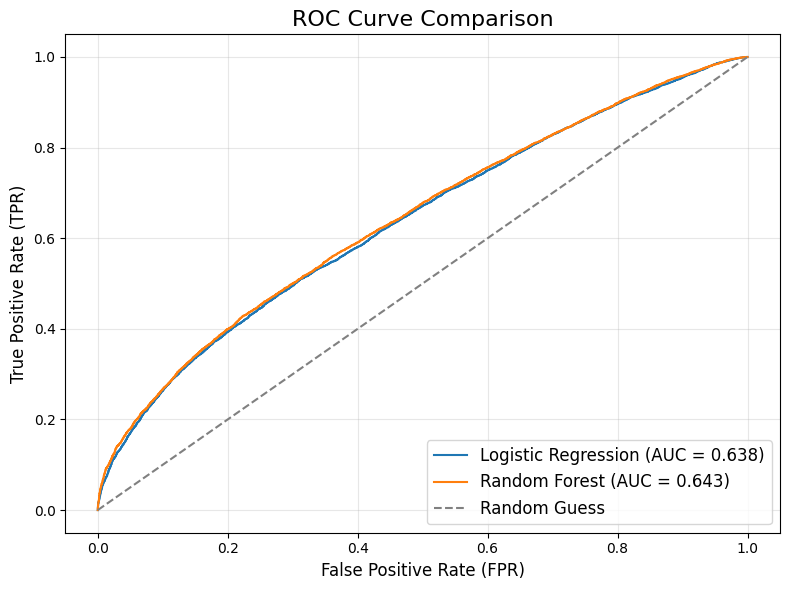

In [ ]:
# @title ROC Curve comparison with random guess
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label="Random Guess")

plt.title("ROC Curve Comparison", fontsize=16)
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
metrics_base = {
    "ROC AUC": roc_auc_score(y_test, y_pred_proba),
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-Score": f1_score(y_test, y_pred),
    "Log-Loss": log_loss(y_test, y_pred_proba)
}

metrics_lr = {
    "ROC AUC": roc_auc_score(y_test, y_pred_proba_lr),
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr),
    "Recall": recall_score(y_test, y_pred_lr),
    "F1-Score": f1_score(y_test, y_pred_lr),
    "Log-Loss": log_loss(y_test, y_pred_proba_lr)
}

metrics_rf = {
    "ROC AUC": roc_auc_score(y_test, y_pred_proba_rf),
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-Score": f1_score(y_test, y_pred_rf),
    "Log-Loss": log_loss(y_test, y_pred_proba_rf)
}

metrics_table = pd.DataFrame({
    "Metric": metrics_lr.keys(),
    "Base": metrics_base.values(),
    "Logistic Regression": metrics_lr.values(),
    "Random Forest": metrics_rf.values()
})

metrics_table = metrics_table.set_index("Metric")
print(metrics_table)

               Base  Logistic Regression  Random Forest
Metric                                                 
ROC AUC    0.637570             0.637609       0.642657
Accuracy   0.613922             0.602288       0.619583
Precision  0.605776             0.563491       0.651343
Recall     0.418358             0.534151       0.341335
F1-Score   0.494918             0.548429       0.447932
Log-Loss   0.654361             0.658479       0.649295


In [ ]:
# @title Feature importance in RF
importances = best_model_rf.feature_importances_
feature_names = [f"'{i}'" for i in df_final.columns[:-1]]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                          Feature  Importance
7                     'SHOT_DIST'    0.215715
9       'PLAY_TYPE_FG_PERCENTAGE'    0.121715
16               'CLOSE_DEF_DIST'    0.088637
20                'PLAY_TYPE_CUT'    0.072991
17       'DEFENDER_FG_PERCENTAGE'    0.054892
6         'SHOOTER_FG_PERCENTAGE'    0.050050
4             'SECONDS_REMAINING'    0.048550
2                  'FINAL_MARGIN'    0.044146
12                     '3PT_SHOT'    0.031392
25  'CONTEST_LEVEL_HEAVY CONTEST'    0.029436
18                  'RATING_DIFF'    0.027462
8   'CONTEST_LEVEL_FG_PERCENTAGE'    0.027182
15              'RATING_DEFENDER'    0.023272
5                        'RATING'    0.022688
14                 'IS_FASTBREAK'    0.019693
27      'CONTEST_LEVEL_OPEN SHOT'    0.015648
21              'PLAY_TYPE_DRIVE'    0.015642
19        'PLAY_TYPE_CATCH&SHOOT'    0.014011
11             'SHOT_CLOCK_PRESS'    0.013532
1                        'IS_WIN'    0.011220
3                        'PERIOD' 

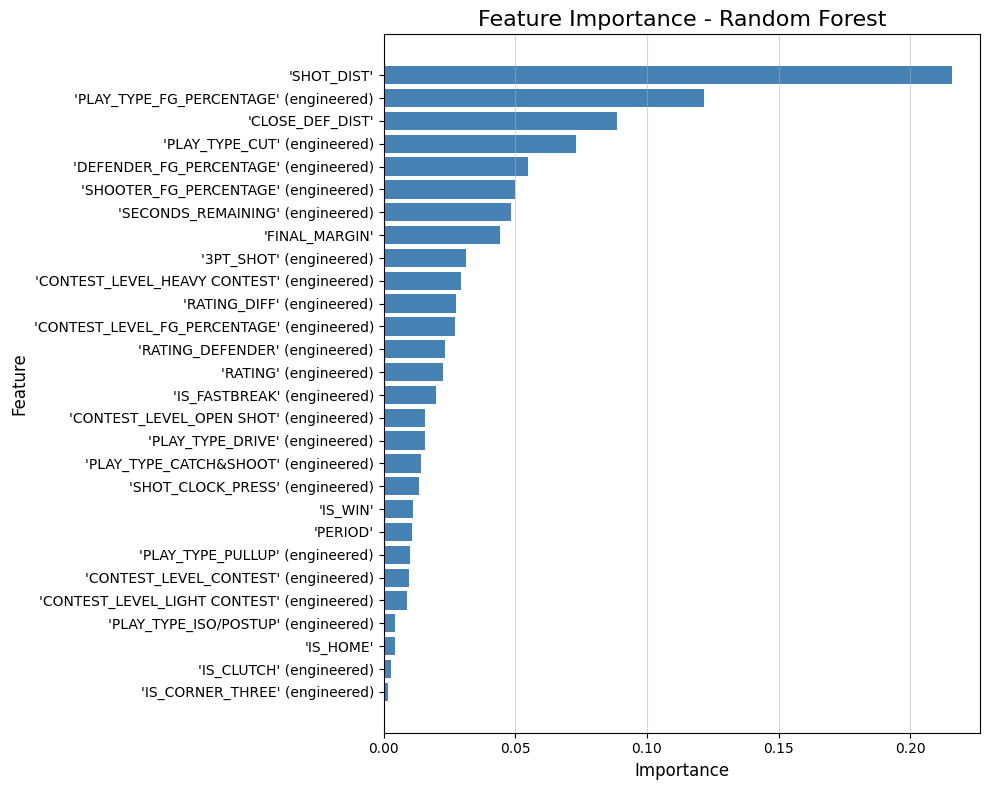

In [ ]:
engineered_features = ['PLAY_TYPE', 'CONTEST_LEVEL', 'IS_CLUTCH', 'SHOT_CLOCK_PRESS', '3PT_SHOT', 'IS_CORNER_THREE', 'IS_FASTBREAK', 'RATING', 'SECONDS_REMAINING', 'PERCENTAGE']
for i in range(len(feature_names)):
  if any(ef in feature_names[i] for ef in engineered_features):
    feature_names[i] = feature_names[i] + ' (engineered)'

importances = best_model_rf.feature_importances_

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.title("Feature Importance - Random Forest", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis="x", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
def evaluate_engineered_feature(feature, filter_value = None):
  if filter_value:
    print('Total: ', df_final[df_final[feature] == filter_value]['FGM'].count())
    print(df_final[df_final[feature] == filter_value][[feature, 'FGM']].value_counts() / df_final[df_final[feature] == filter_value]['FGM'].count())
  else:
    print('Total: ', df_final['FGM'].count())
    print(df_final[[feature, 'FGM']].value_counts() / df_final['FGM'].count())
  print()


evaluate_engineered_feature('PLAY_TYPE_CUT', 1)
evaluate_engineered_feature('CONTEST_LEVEL_HEAVY CONTEST', 1)
evaluate_engineered_feature('IS_CORNER_THREE', 1)
evaluate_engineered_feature('PLAY_TYPE_PULLUP', 1)
evaluate_engineered_feature('IS_FASTBREAK', 1)

Total:  17895
PLAY_TYPE_CUT  FGM
1              1      0.663314
               0      0.336686
Name: count, dtype: float64

Total:  25962
CONTEST_LEVEL_HEAVY CONTEST  FGM
1                            0      0.548224
                             1      0.451776
Name: count, dtype: float64

Total:  5898
IS_CORNER_THREE  FGM
1                0      0.613259
                 1      0.386741
Name: count, dtype: float64

Total:  34138
PLAY_TYPE_PULLUP  FGM
1                 0      0.611313
                  1      0.388687
Name: count, dtype: float64

Total:  28647
IS_FASTBREAK  FGM
1             1      0.529654
              0      0.470346
Name: count, dtype: float64



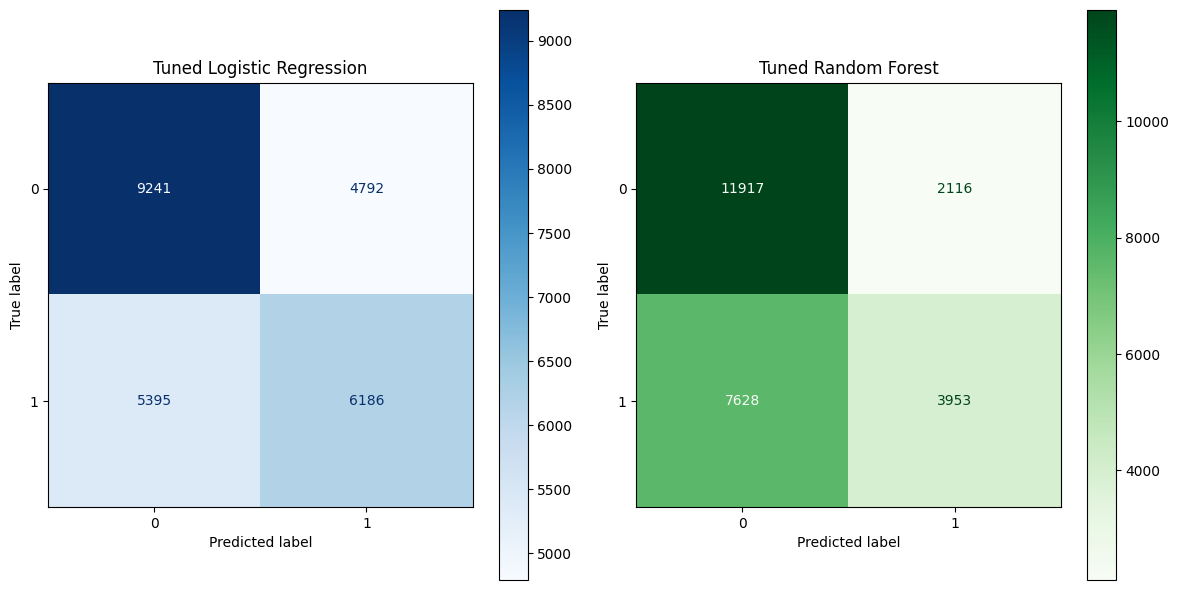

In [ ]:
# @title Confusion matrices
y_pred_lr = best_model_lr.predict(X_test)
y_pred_rf = best_model_rf.predict(X_test)

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=best_model_lr.classes_)
disp_lr.plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Tuned Logistic Regression")

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_model_rf.classes_)
disp_rf.plot(ax=axes[1], cmap='Greens')
axes[1].set_title("Tuned Random Forest")

plt.tight_layout()
plt.show()